<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#To-load-the-data" data-toc-modified-id="To-load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>To load the data</a></span></li><li><span><a href="#Load-the-strong-annotation-and-the-ground-thruth" data-toc-modified-id="Load-the-strong-annotation-and-the-ground-thruth-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the strong annotation and the ground thruth</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimization</a></span><ul class="toc-item"><li><span><a href="#Threshold" data-toc-modified-id="Threshold-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Threshold</a></span></li><li><span><a href="#Threshold-+-smoothing" data-toc-modified-id="Threshold-+-smoothing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Threshold + smoothing</a></span></li><li><span><a href="#Hysteris-+-smoothing" data-toc-modified-id="Hysteris-+-smoothing-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hysteris + smoothing</a></span></li></ul></li><li><span><a href="#Gen-Optimization" data-toc-modified-id="Gen-Optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Gen Optimization</a></span></li></ul></div>

# Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import os
import matplotlib.pyplot as plt
import dcase_util as dcu

from Encoder import Encoder

import numpy as np

import matplotlib.pyplot as plt

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", grid=True)
jtplot.base_context["grid.linewidth"] = 0.2

# To load the data

In [2]:
import numpy as np
import os

class_correspondance = {"Alarm_bell_ringing": 0, "Speech": 1, "Dog": 2, "Cat": 3, "Vacuum_cleaner": 4,
                        "Dishes": 5, "Frying": 6, "Electric_shaver_toothbrush": 7, "Blender": 8, "Running_water": 9}


def load_mil():
    strong_prediction = np.load(os.path.join("..", "data", "mil_strong_prediction.pkl"))
    tmp = dict()

    # Fill the missing curve with zero
    for filename in strong_prediction:
        new_data = np.zeros((431, 10))

        for cls in strong_prediction[filename]:
            new_data[:, class_correspondance[cls]] = strong_prediction[filename][cls]

        tmp[filename] = new_data.copy()

    # Create a list of filename in the same order than the dict
    filename_list = ["%s.wav" % k for k in tmp.keys()]

    # Create a list
    output_data = np.array(list(tmp.values()))

    return output_data, filename_list


def load_baseline():
    filenames = np.load(os.path.join("..", "data", "X_test_fn.npy"))
    strong_prediction = np.load(os.path.join("..", "data", "baseline_strong_prediction.npy"))

    return strong_prediction, filenames


def load_strong_prediction(filename):
    filenames = np.load(os.path.join("..", "data", "X_test_fn.npy"))
    strong_prediction = np.load(os.path.join("data", filename))
    
    return strong_prediction, filenames


def load_ground_truth():
    test_unique_names = np.load(os.path.join("..", "data", "X_test_fn.npy"))

    with open(os.path.join("data", "test.csv"), "r") as f:
        test_metadata = f.read().splitlines()[1:]
    test_metadata = np.array([info.split("\t") for info in test_metadata])
    test_medata_filenames = np.unique(test_metadata[:, 0])

    y_test = []
    for name in test_medata_filenames:
        # remove  missing files
        if name not in test_unique_names:
            continue

        # create a tag level prediction (aka weak labels)
        output = [0] * 10

        for d in test_metadata:
            if d[0] == name:
                output[class_correspondance[d[-1]]] = 1
        y_test.append(output)
    y_test = np.array(y_test)

    return y_test


# Load the strong annotation and the ground thruth

In [3]:
# strong_annotation, filenames = Loader.load_mil()
strong_prediction, filenames = load_mil()

# ground truth
with open(os.path.join("..", "data", "test.csv"), "r") as f:
    strong_y_true = f.read().splitlines()[1:]

In [4]:
strong_prediction.shape

(279, 431, 10)

# Optimization

In [5]:
from Encoder import Encoder
from optimizers import DichotomicOptimizer, GenOptimizer

In [15]:
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

## Threshold

In [8]:
t = list(np.random.normal(0.5, 0.1, size=1000))


In [16]:
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "threshold": (0.01, 0.1)
    },
    
    encoder = encoder,
    step = 10,
    nb_recurse = 3,
    nb_process = 12
)

# Perform the optimization
%time optimizer.fit(strong_y_true, strong_prediction, filenames, verbose=2)

CPU times: user 364 ms, sys: 790 ms, total: 1.15 s
Wall time: 10.7 s


Process ForkPoolWorker-231:
Process ForkPoolWorker-229:
Process ForkPoolWorker-225:
Process ForkPoolWorker-224:
Process ForkPoolWorker-230:
Process ForkPoolWorker-222:
Process ForkPoolWorker-223:
Process ForkPoolWorker-221:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6

In [7]:
# monitor one metrics
def monitor_one(results, metric):
    out = []
    
    for k in results.keys():
        out.append((k, results[k]["overall"]["f_measure"][metric]))
        
    out = sorted(out, key=lambda x: x[0])
    
    return np.array(out)

def display_history(metric):
    x, y = metric[:, 0], metric[:, 1]

    max_y = max(y)
    max_x = list(y).index(max_y)
    print(max_x, max_y)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.title("f_measure")
    plt.plot(range(len(y)), y, label="f1")
    plt.plot(max_x, max_y, "ro", label="f1:%.2f" % (max_y, ))

    plt.ylabel("f1")
    plt.xlabel("threshold")
    plt.xticks([0, len(x)], [0, len(x)])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(list(y))
    plt.show()
    
    return x[list(y).index(max_y)]

2 0.27093412727949384


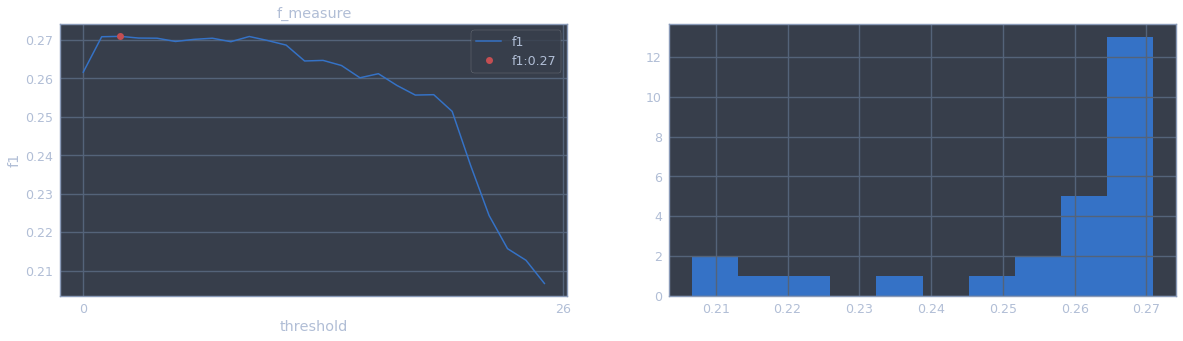

In [17]:
f1 = monitor_one(optimizer.results, "f_measure")
best_combination = display_history(f1)

## Threshold + smoothing

In [18]:
## Threshold smoothing and smoothing window size
# Create the optimizer
optimizer = Optimizer.ThresholdOptimizer(
    {
        "threshold": (0.01, 0.1),
        "smooth": "smoothMovingAvg",
        "window_len": [3, 7, 11, 13, 15, 17, 19, 21]
    },
    
    encoder = encoder,
    step = 12,
    nb_recurse = 3,
    nb_process = 20
)

# Perform the optimization
%time optimizer.fit(y_true, strong_prediction, filenames, verbose=2)

NameError: name 'Optimizer' is not defined

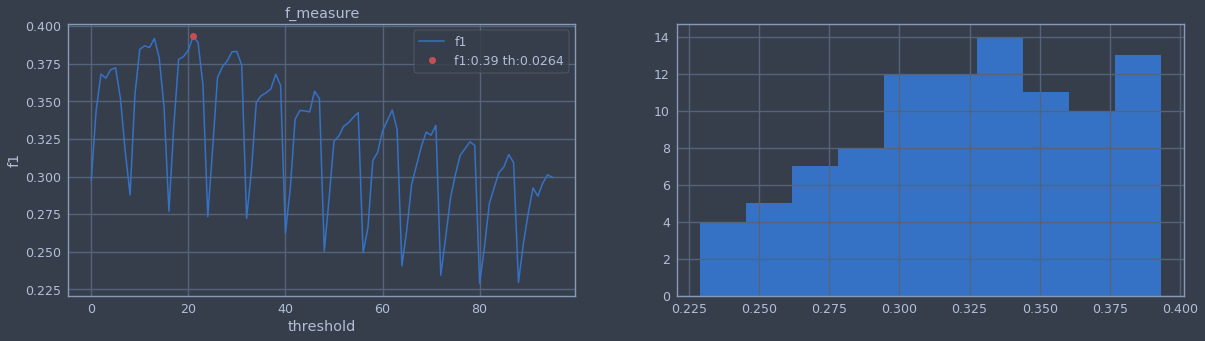

(0.026363636363636367, 'smoothMovingAvg', 17)


In [40]:
f1 = monitor_one(optimizer.results, "f_measure")
best_combination = display_history(f1)
print(best_combination)

## Hysteris + smoothing

In [ ]:
## Threshold smoothing and smoothing window size
# Create the optimizer
optimizer = Optimizer.ThresholdOptimizer(
    {
        "low": (0.01, 0.9),
        "high": [0.1, 0.2, 0.4],
        "smooth": "smoothMovingAvg",
        "window_len": (3, 29)
    },
    
    encoder = encoder,
    step = 12,
    nb_recurse = 3,
    nb_process = 20
)

# Perform the optimization
%time optimizer.fit(y_true, strong_prediction, filenames, method="hysteresis", verbose=2)

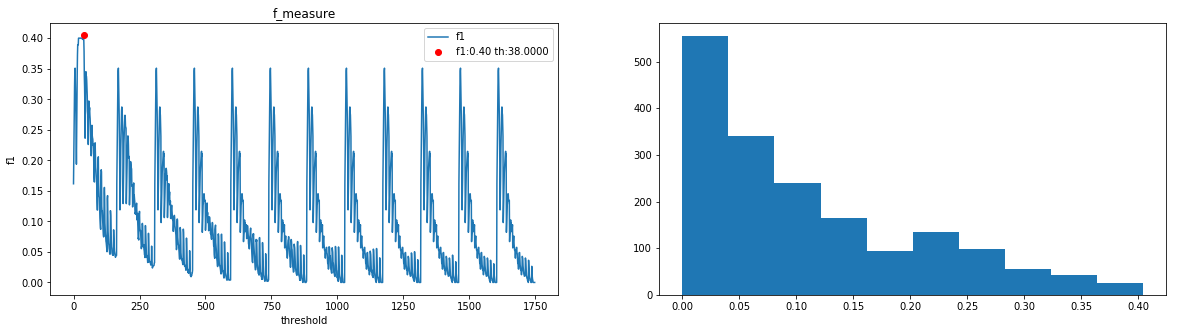

(0.01, 0.09090909090909091, 'smoothMovingAvg', 17.181818181818183)


In [30]:
f1 = monitor_one(optimizer.results, "f_measure")
best_combination = display_history(f1)
print(best_combination)

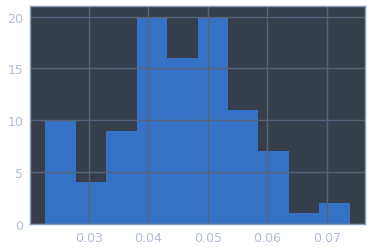

100
100


In [25]:
tupl = (0.01, 0.1)
mean = (tupl[1] - tupl[0]) / 2
std = mean / 4

t = np.random.normal(mean, std, size=100)
t = np.clip(t, a_min=0, a_max=1)

_, _, _ = plt.hist(t)
plt.show()

print(len(t))
print(len(np.unique(t)))

# Gen Optimization

In [13]:
## Threshold smoothing and smoothing window size
class_list = ['Alarm_bell_ringing', 'Speech', 'Dog', 'Cat', 'Vacuum_cleaner', 'Dishes', 'Frying', 'Electric_shaver_toothbrush', 'Blender', 'Running_water']

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 200,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 200 # ms
)

# Create the optimizer
optimizer = GenOptimizer(
    {
        "threshold": (0.01, 0.09),
        "window_len": [10,13, 15, 17, 19, 21, 23, 25, 27, 29]
    },
    
    encoder = encoder,
    step = 10,
    nb_recurse = 2,
    nb_process = 20
)

# Perform the optimization
%time optimizer.fit(strong_y_true, strong_prediction, filenames, verbose=2)

{'threshold': ([0.04179536389936982, 0.044457576682460656, 0.039085196127093526, 0.0256463161129225, 0.03640965629886248, 0.03513533402065397, 0.023788216627758294, 0.025679178457074216, 0.0287799407355912, 0.044195956684411175],), 'window_len': [10, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
{'threshold': ([0.056046618591158726, 0.06183844752576512, 0.030277165261169955, 0.017516077521373855, 0.03400274886186217, 0.05029100367764312, 0.01609287293829003, 0.02352724022617206, 0.025427351348344528, 0.035077665049364895],), 'window_len': [10, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
CPU times: user 255 ms, sys: 610 ms, total: 865 ms
Wall time: 6.82 s


Process ForkPoolWorker-207:
Process ForkPoolWorker-215:
Process ForkPoolWorker-202:
Process ForkPoolWorker-214:
Process ForkPoolWorker-213:
Process ForkPoolWorker-201:
Process ForkPoolWorker-216:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lcances/.miniconda3/envs/dcase/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lcances/.miniconda3/envs/dcase/lib/py

16 0.27073552425665104


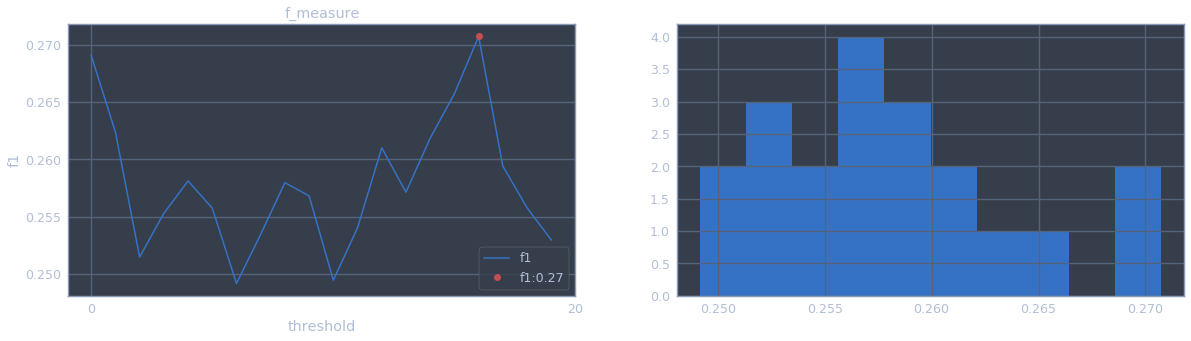

((0.056046618591158726,
  0.06183844752576512,
  0.030277165261169955,
  0.017516077521373855,
  0.03400274886186217,
  0.05029100367764312,
  0.01609287293829003,
  0.02352724022617206,
  0.025427351348344528,
  0.035077665049364895),
 27)

In [14]:
f1 = monitor_one(optimizer.results, "f_measure")

display_history(f1)